# [quantumswitch.ipynb](https://github.com/lafefspietz/quantumswitch/blob/main/quantumswitch.ipynb)

In [17]:
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pyvisa
import time
import datetime
import serial
rm = pyvisa.ResourceManager()
rm.list_resources()
from MS461xx_RawSockets_example import *

#jupyter notebook --notebook-dir=c:\xampp\htdocs\quantumswitch

In [18]:
shockline_socket = InstrumentSocketConnection('* TCPIP0::132.163.130.56::5001::SOCKET', 30)

In [19]:
shockline_socket.query("*IDN?")

'ANRITSU,MS46122B,2250307,V2023.7.5,V2.3.20'

In [20]:
import serial.tools.list_ports
ports = serial.tools.list_ports.comports()

for port, desc, hwid in sorted(ports):
        print("{}: {} [{}]".format(port, desc, hwid))

COM1: Communications Port (COM1) [ACPI\PNP0501\0]
COM3: Intel(R) Active Management Technology - SOL (COM3) [PCI\VEN_8086&DEV_A2BD&SUBSYS_07381028&REV_00\3&11583659&1&B3]
COM4: Arduino Uno (COM4) [USB VID:PID=2341:0043 SER=7503330323435151C020 LOCATION=1-10.1.2]
COM5: USB Serial Device (COM5) [USB VID:PID=3343:0043 SER=851363038373519150A0 LOCATION=1-10.1.1]


In [24]:
Sparameter_select_serial = serial.Serial('COM4', 9600)  # open serial port

In [25]:
SP9T_serial = serial.Serial('COM5', 9600)  # open serial port

In [22]:
Sparameter_select_serial.close()

In [23]:
SP9T_serial.close()

In [162]:
quantumswitchdata = json.loads('{}')
quantumswitchdata['dataurl'] = "https://github.com/lafefspietz/quantumswitch/blob/main/quantumswitchdata.txt"
quantumswitchdata['ipynb'] = "https://github.com/lafefspietz/quantumswitch/blob/main/quantumswitch.ipynb"
quantumswitchdata['email'] = "lafe.f.spietz@nist.gov"
quantumswitchdata['author'] = "Lafe Spietz"
quantumswitchdata['license'] = "Public Domain"
quantumswitchdata['repository'] = "https://github.com/lafefspietz/quantumswitch"
quantumswitchdata['location'] = "Boulder, Co, USA"
quantumswitchdata['organization'] = "NIST"
quantumswitchdata['fridge'] = "XLD Dilution refrigerator in wing 3 of Building 1 at NIST, Boulder"
quantumswitchdata['localdata'] = "grumpy\lafe\MEMS switches\data\XLD_calibration_fall_2024"
x = datetime.datetime.now()
quantumswitchdata['experiment'] = "SOLT calibration with version 1 of quantum switch and superconducting thru chip" 
quantumswitchdata['startdatetime'] = x.strftime("%c")
quantumswitchdata['starttimestamp'] = int(time.time())
quantumswitchdata['f'] = np.array([]).tolist()
quantumswitchdata['fGHz'] = np.array([]).tolist()
quantumswitchdata['RBW'] = 0
quantumswitchdata['Power'] = 0
quantumswitchdata['devicenames']  = ['short12589',
                                     'open12589',
                                     'short3467',
                                     'open3467',
                                     'load12589',
                                     'load3467',
                                     'thru3467',
                                     'thru12589',
                                     'thru_chip']

# Get frequency points and turn them into a array
fstring = shockline_socket.query(":SENS1:FREQ:DATA?")
fstringarray = fstring.split(' ')[1:len(fstring.split(' '))]
quantumswitchdata['f'] = []
for index in range(len(fstringarray)):
    quantumswitchdata['f'].append(float(fstringarray[index]))
    
for port in range(1,10):
    time.sleep(1.0)
    SP9T_serial.write(bytes(str(port), encoding='utf-8'))
    for sparamselect in range(1,5):
        if sparamselect == 1:
            sparam = 'S11'
        if sparamselect == 2:
            sparam = 'S22'
        if sparamselect == 3:
            sparam = 'S21'
        if sparamselect == 4:
            sparam = 'S12'
        Sparameter_select_serial.write(bytes(str(sparamselect), encoding='utf-8')) # S11,S22,S21,S12
        time.sleep(10.0)

        realtrace = sparam + "port" + str(port) + "real"
        imagtrace = sparam + "port" + str(port) + "imag"
        
        quantumswitchdata[realtrace] = []
        quantumswitchdata[imagtrace] = []    
        datastring = shockline_socket.query(":CALC1:PAR1:DATA:SDAT?")
        datastringarray = datastring.split('\n')
        datastringarray[0] = datastringarray[0].split('#9000029999')[1]# why is this mysterious long number always inserted?
        for index in range(len(datastringarray)):
            r1 = float(datastringarray[index].split(',')[0])
            i1 = float(datastringarray[index].split(',')[1])
            quantumswitchdata[realtrace].append(r1)
            quantumswitchdata[imagtrace].append(i1)

In [49]:
filename = "quantumswitchdata.txt"
jsonstring = json.dumps(quantumswitchdata,indent=4)
file = open(filename, 'w')
file.write(jsonstring)
file.close()

In [82]:
file = open('quantumswitchdata.txt', "r")
rawjson = file.read()
quantumswitchdata = json.loads(rawjson)
file.close()

In [140]:
frequency = np.array(quantumswitchdata['f'])
devicenames = quantumswitchdata['devicenames']
S11complex = {}
S21complex = {}
S11logmag = {}
S21logmag = {}
S11phase = {}
S21phase = {}

for portnumber in range(1,10):
    S11complex[devicenames[portnumber-1]] = np.array(quantumswitchdata['S11port'  + str(portnumber) + 'real']) + 1j*np.array(quantumswitchdata['S11port'  + str(portnumber) + 'imag'])
    S21complex[devicenames[portnumber-1]] = np.array(quantumswitchdata['S21port'  + str(portnumber) + 'real']) + 1j*np.array(quantumswitchdata['S21port'  + str(portnumber) + 'imag'])
    S11logmag[devicenames[portnumber-1]]  = 10*np.log10(np.abs(S11complex[devicenames[portnumber-1]])**2)
    S21logmag[devicenames[portnumber-1]]  = 10*np.log10(np.abs(S21complex[devicenames[portnumber-1]])**2)
    S11phase[devicenames[portnumber-1]] = np.unwrap(np.angle(S11complex[devicenames[portnumber-1]],deg=True))
    S21phase[devicenames[portnumber-1]] = np.unwrap(np.angle(S21complex[devicenames[portnumber-1]],deg=True))
    

(4, 8)

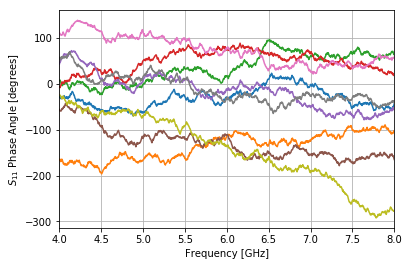

In [158]:
plt.plot(frequency/1e9,S11phase[devicenames[0]])
plt.plot(frequency/1e9,S11phase[devicenames[1]])
plt.plot(frequency/1e9,S11phase[devicenames[2]])
plt.plot(frequency/1e9,S11phase[devicenames[3]])
plt.plot(frequency/1e9,S11phase[devicenames[4]])
plt.plot(frequency/1e9,S11phase[devicenames[5]])
plt.plot(frequency/1e9,S11phase[devicenames[6]])
plt.plot(frequency/1e9,S11phase[devicenames[7]])
plt.plot(frequency/1e9,S11phase[devicenames[8]])

plt.grid()
plt.xlabel('Frequency [GHz]')
plt.ylabel('$S_{11}$ Phase Angle [degrees]')
#plt.ylim((-60,0))
plt.xlim((4,8))
#plt.legend(['$|S_{11}|^2$','$|S_{22}|^2$','$|S_{21}|^2$','$|S_{12}|^2$'])

(6, 7)

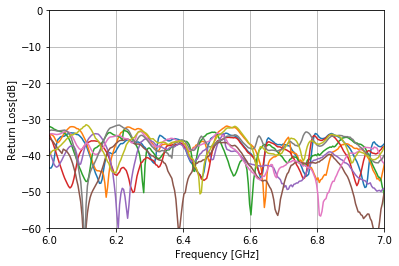

In [156]:
plt.plot(frequency/1e9,S11logmag[devicenames[0]])
plt.plot(frequency/1e9,S11logmag[devicenames[1]])
plt.plot(frequency/1e9,S11logmag[devicenames[2]])
plt.plot(frequency/1e9,S11logmag[devicenames[3]])
plt.plot(frequency/1e9,S11logmag[devicenames[4]])
plt.plot(frequency/1e9,S11logmag[devicenames[5]])
plt.plot(frequency/1e9,S11logmag[devicenames[6]])
plt.plot(frequency/1e9,S11logmag[devicenames[7]])
plt.plot(frequency/1e9,S11logmag[devicenames[8]])
plt.grid()
plt.xlabel('Frequency [GHz]')
plt.ylabel('Return Loss[dB]')
plt.ylim((-60,0))
plt.xlim((6,7))

(4, 8)

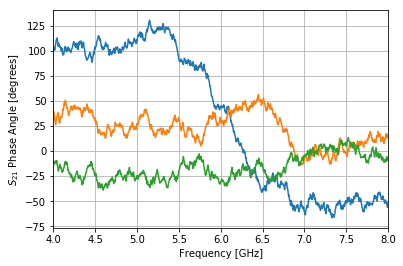

In [159]:

plt.plot(frequency/1e9,S21phase[devicenames[6]])
plt.plot(frequency/1e9,S21phase[devicenames[7]])
plt.plot(frequency/1e9,S21phase[devicenames[8]])

plt.grid()
plt.xlabel('Frequency [GHz]')
plt.ylabel('$S_{21}$ Phase Angle [degrees]')
#plt.ylim((-60,0))
plt.xlim((4,8))